### BP Smoky Mountain Data Challenge

#### Author: Max Grossman (max.grossman@bp.com)

This notebook is intended to be an illustrative example of loading the realizations and gathers provided as part of the BP problem in the 2020 Smoky Mountain Data Challenge. This notebook relies on data files kept under the small_dataset/ folder provided with the data challenge. Please ensure that the folder is downloaded and unzipped, and placed in the same directory as this notebook.

This notebook requires that the numpy, matplotlib, pillow, and segpy packages be installed in the current Python environment. numpy, matplotlib, and pillow may be installed using pip or conda. segpy is only available from pip (i.e. 'pip install segpy').

In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install segpy
%matplotlib inline
import math
import segpy
from segpy.reader import create_reader
from segpy.writer import write_segy
import os
import numpy as np
import matplotlib
import matplotlib.pyplot
from PIL import Image

In [3]:
"""
Utility for pulling information out of SEGY header and printing it for the user.
"""
def print_segy_info(filename):
    with open(filename, 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')

        print("Filename:             ", segy_reader.filename)
        print("SEG Y revision:       ", segy_reader.revision)
        print("Number of traces:     ", segy_reader.num_traces())
        print("Data format:          ",
              segy_reader.data_sample_format_description)
        print("Dimensionality:       ", segy_reader.dimensionality)

        print()
        print("=== BEGIN TEXTUAL REEL HEADER ===")
        for line in segy_reader.textual_reel_header:
            if len(line.strip()) > 0:
                print(line)
        print("=== END TEXTUAL REEL HEADER ===")

In [4]:
"""
The provided files ending with a .stack.segy suffix store realizations of the subsurface
using some plausible (but not perfect) velocity model.

These realizations are 2D, with a depth (z) dimension of 400 and a horizontal (x) dimension
of 1058. This information can be seen in the SEGY header displayed below.
"""
print_segy_info('Desktop/BP HPC/small_dataset/small_dataset/img_1.stack.segy')


Filename:              Desktop/BP HPC/small_dataset/small_dataset/img_1.stack.segy
SEG Y revision:        SegYRevision.REVISION_0
Number of traces:      1058
Data format:           IBM 32 bit float
Dimensionality:        0

=== BEGIN TEXTUAL REEL HEADER ===
C01  BP syntheitc Date: 05/20/2019                                              
C02  image stack scenario with the following dimension                          
C03  axis  :         z         x         y                                      
C04  size  :       400      1058         1                                      
C05  origin:   0.00000   0.00000   0.00000                                      
C06  delta :  10.00000  10.00000  10.00000                                      
=== END TEXTUAL REEL HEADER ===


In [5]:
"""
Example of loading a single 2D realization from a single file into a 2D numpy array, with x
as your leading dimension and z as your innermost dimension. We know the x and z dimensions
(1058 and 400) from the SEGY header printed by the cell above.
"""
REALIZATIONS = 59
deviations = np.zeros((1058, 400))
means = np.zeros((1058, 400))
totals = np.zeros((1058, 400))
PATH = "Desktop/BP HPC/small_dataset/small_dataset"
                    

In [ ]:
for file in os.listdir(PATH):
    if file.endswith(".stack.segy"):
        print(file)
        path = "Desktop/BP HPC/small_dataset/small_dataset/"+ file
        with open(path, 'rb') as segy_in_file:
            segy_reader = create_reader(segy_in_file, endian='>')
            for trace_index in segy_reader.trace_indexes():
                data = segy_reader.trace_samples(trace_index)
                for i in range(len(data)):
                    means[trace_index, i] += data[i]/REALIZATIONS #Collecting means, storing in array

img_1.stack.segy
img_10.stack.segy
img_11.stack.segy


In [ ]:
#Probably better way than to rerun over files :( 
for file in os.listdir(PATH):
    if file.endswith(".stack.segy"):
        print(file)
        path = "Desktop/BP HPC/small_dataset/small_dataset/"+ file
        with open(path, 'rb') as segy_in_file:
            segy_reader = create_reader(segy_in_file, endian='>')
            for trace_index in segy_reader.trace_indexes():
                data = segy_reader.trace_samples(trace_index)
                for i in range(len(data)):
                    totals[trace_index, i] += (data[i] - means[trace_index, i]) ** 2


In [ ]:
import math
#print("Deviations: Rows", len(deviations), "Cols ", len(deviations[0]))
#print("Cell - Mean: Rows", len(totals) , "Cols ", len(totals[0]))
#print("Mean: Rows", len(means), "Cols", len(means[0]))

for i in range(len(deviations)):
    for j in range(len(deviations[0])):

        deviations[i][j] = math.sqrt(totals[i][j]/REALIZATIONS)


In [ ]:
deviations.min(), deviations.max()

In [ ]:
import pandas as pd
#Make copies of deviations to avoid manipulating true data
flat_deviations = deviations.flatten()
print("Max STD: ",deviations.max())
df = pd.Series(flat_deviations)
df.plot(kind='hist', figsize = (25, 6), bins=200, title = "Distribution of Standard Deviations")

In [1]:
SAMPLE_REAL = "Desktop/BP HPC/small_dataset/small_dataset/img_1.stack.segy"
sample_arr = np.zeros([1058, 400, 3], dtype=np.uint8)
gray_sample_arr = np.zeros((1058, 400))
with open(SAMPLE_REAL, 'rb') as segy_in_file:
    segy_reader = create_reader(segy_in_file, endian='>')
    for trace_index in segy_reader.trace_indexes():
        data = segy_reader.trace_samples(trace_index)
        for i in range(len(data)):
            gray_sample_arr[trace_index, i] = data[i]
with open(SAMPLE_REAL, 'rb') as segy_in_file:
    segy_reader = create_reader(segy_in_file, endian='>')
    for trace_index in segy_reader.trace_indexes():
        data = segy_reader.trace_samples(trace_index)
        for i in range(len(data)):
            sample_arr[trace_index, i] = [data[i], 0, 0] #Collecting data for sample_arr

min_arr = gray_sample_arr.min()
max_arr = gray_sample_arr.max()
gray_sample_arr = (gray_sample_arr - min_arr) / (max_arr - min_arr) #Normalizes all values to 0 - 1
gray_sample_arr = gray_sample_arr * 255
for i in range(len(gray_sample_arr)):
    for j in range(len(gray_sample_arr[0])):
        sample_arr[i][j] = [gray_sample_arr[i][j], gray_sample_arr[i][j], gray_sample_arr[i][j]]

NameError: name 'np' is not defined

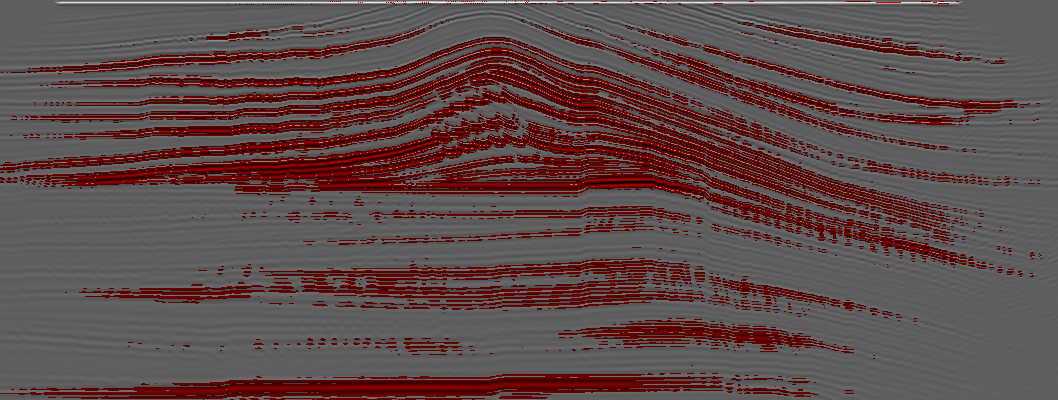

In [80]:
THRESHOLD = 2.0 #If STD > THRESHOLD plot
max_dev = deviations_copy.max()
deviations_copy = deviations.copy()
for i in range(len(deviations_copy)):
    for j in range(len(deviations_copy[0])):
        if deviations_copy[i][j] >= THRESHOLD:
            color_intensity = sample_arr[i][j][0]
            sample_arr[i][j] = [color_intensity, 0, 0]

im = Image.fromarray(sample_arr)
im = im.convert('RGB')
transposed  = im.transpose(Image.ROTATE_270)


transposed

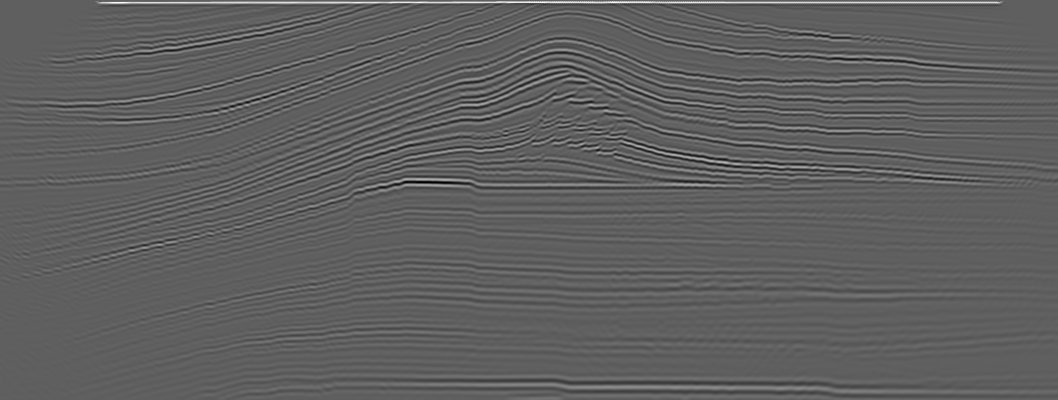

In [81]:

gray_sample_arr = gray_sample_arr.transpose() #Reformat 
min_arr = gray_sample_arr.min()
max_arr = gray_sample_arr.max()
gray_sample_arr = (gray_sample_arr - min_arr) / (max_arr - min_arr) #Normalizes all values to 0 - 1
gray_sample_arr = gray_sample_arr * 255  #Multiply everything to RGB Scale
im = Image.fromarray(gray_sample_arr)
im = im.convert('RGB')

im

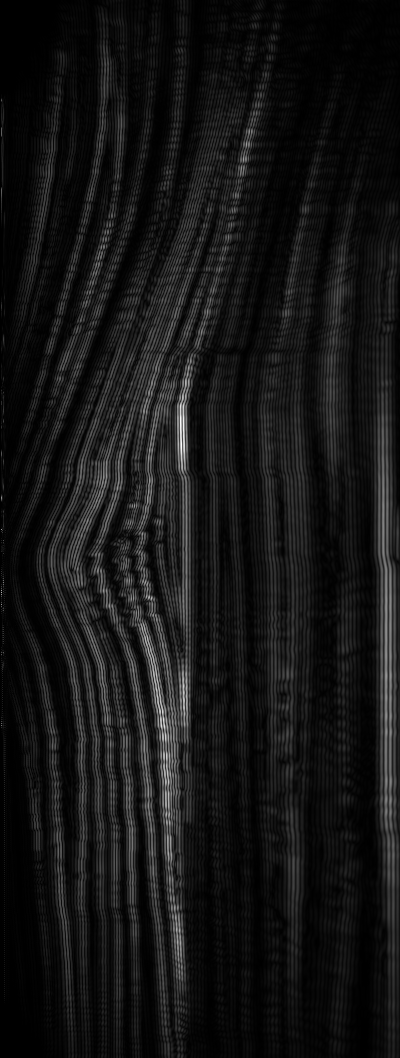

In [27]:
"""
Render the loaded realization by transposing it (so that the image is oriented intuitively) and normalizing.
"""

deviations = deviations.transpose()
min_arr = deviations.min()
max_arr = deviations.max()
deviations = (deviations - min_arr) / (max_arr - min_arr)
deviations = deviations * 255

im = Image.fromarray(deviations)
im = im.convert('RGB')
im

TypeError: array() missing required argument 'object' (pos 1)

In [19]:
"""
The provided files ending with a .gather.segy suffix store offset pair gathers generated
using some plausible (but not perfect) velocity model. Each offset pair gather file corresponds
with a single realization.

These gather files are 3D, with 39 offset pairs in the survey. The z and x dimensions are the
same as the realizations, with an added dimension indicating the offset pair. This information
can be seen in the SEGY header displayed below.
"""
print_segy_info('Desktop/BP HPC/small_dataset/small_dataset/img_3.gather.segy')

Filename:              Desktop/BP HPC/small_dataset/small_dataset/img_3.gather.segy
SEG Y revision:        SegYRevision.REVISION_0
Number of traces:      41262
Data format:           IBM 32 bit float
Dimensionality:        0

=== BEGIN TEXTUAL REEL HEADER ===
C01  BP syntheitc Date: 05/20/2019                                              
C02  image gather scenario with the following dimension                         
C03 axis  :         z    offset         x         y                             
C04 size  :       400        39      1058         1                             
C05 origin:   0.00000   0.00000   0.00000   0.00000                             
C06 delta :  10.00000  80.00000  10.00000  10.00000                             
=== END TEXTUAL REEL HEADER ===


In [15]:
"""
Load gathers into a 3D numpy array with dimensions (x, offsets, z).
"""
arr = np.zeros((1058, 39, 400))
with open('Desktop/BP HPC/small_dataset/small_dataset/img_3.gather.segy', 'rb') as segy_in_file:
    segy_reader = create_reader(segy_in_file, endian='>')
    
    count = 0
    for trace_index in segy_reader.trace_indexes():
        data = segy_reader.trace_samples(trace_index)
        for i in range(len(data)):
            arr[int(trace_index / 39), trace_index % 39, i] = data[i]

In [26]:
arr.min(), arr.max()

(-26.029754638671875, 41.17366027832031)

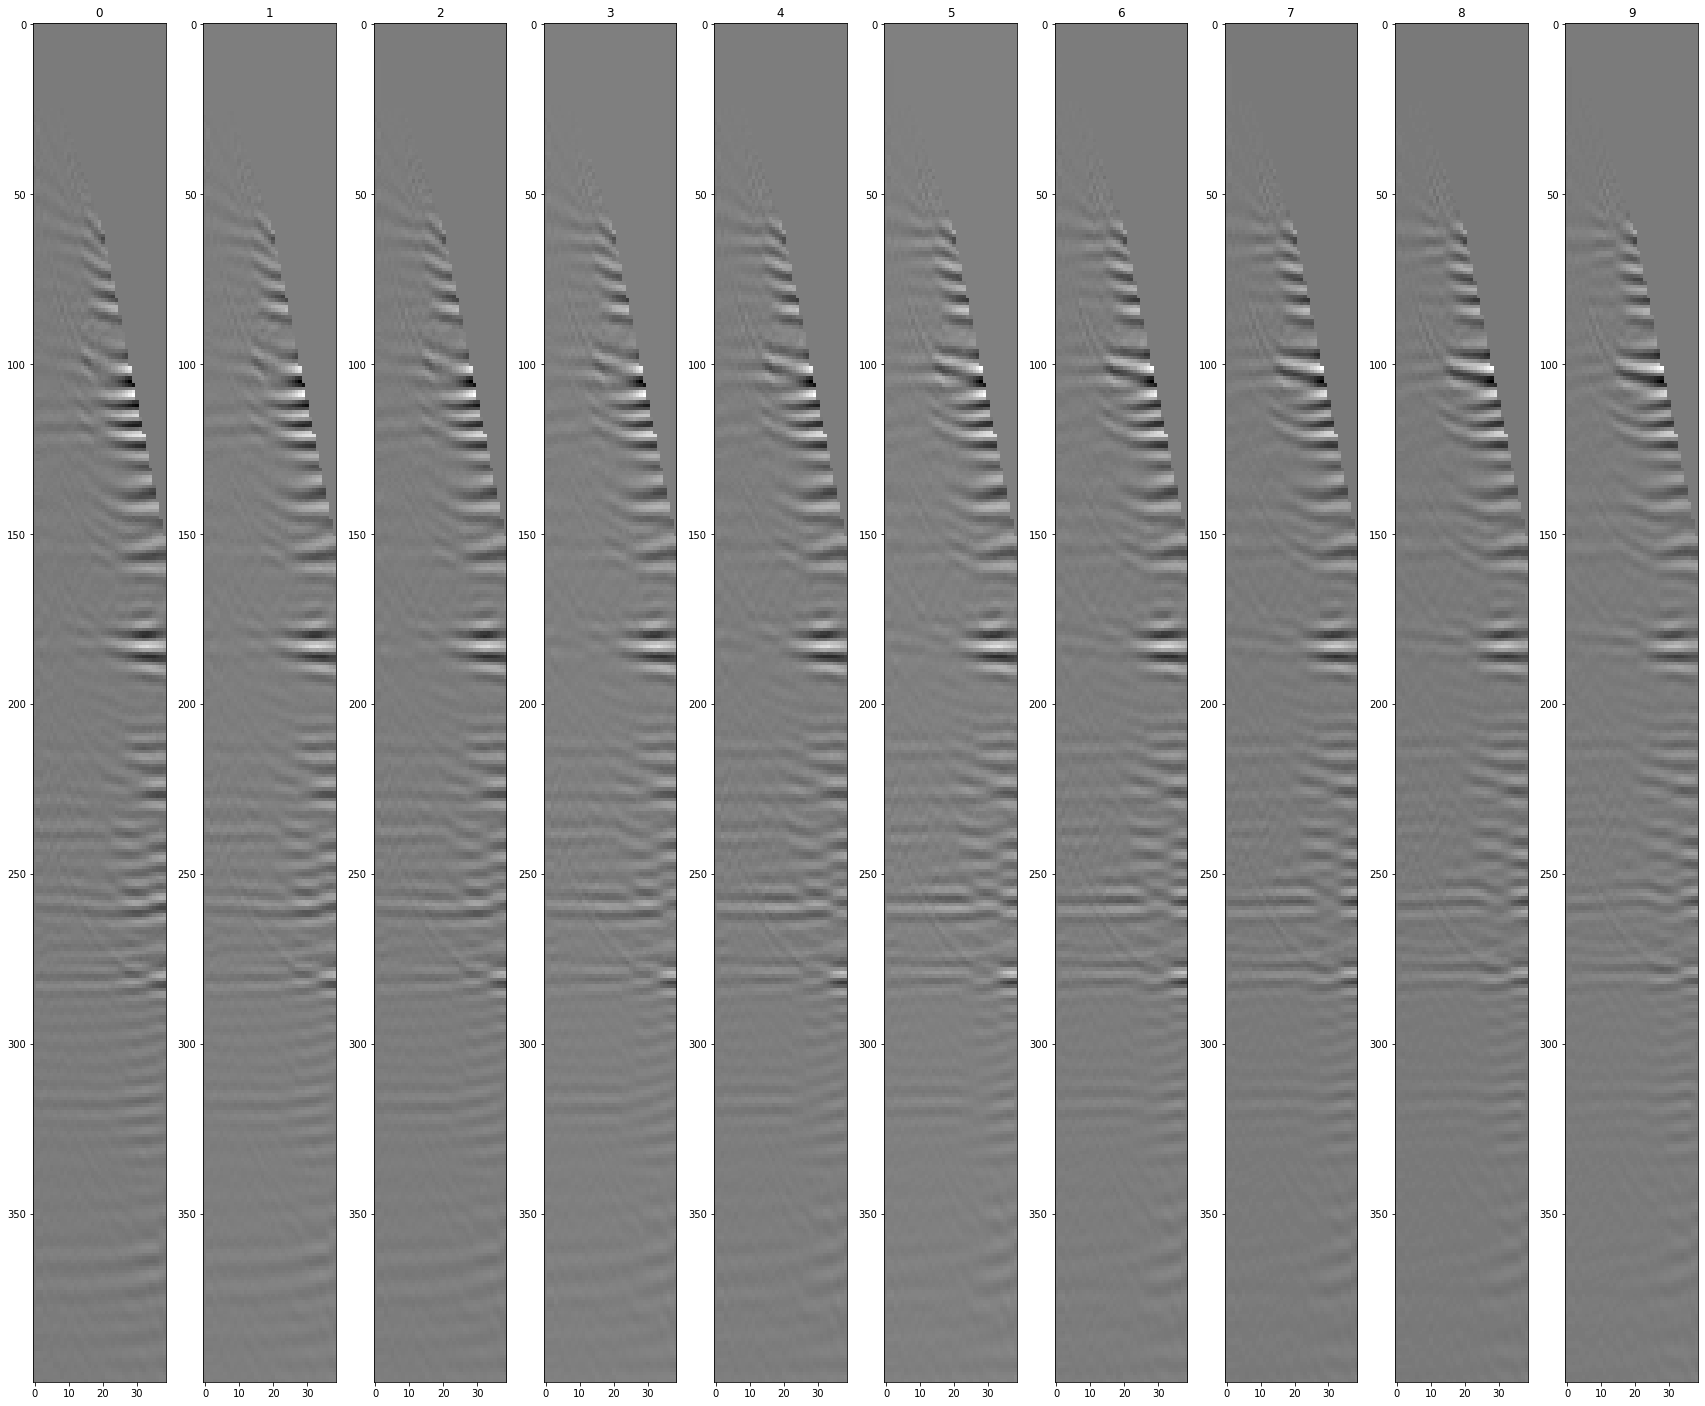

In [17]:
"""
Render the loaded gathers.
"""

nrows = 1
ncols = 10
f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (30, 25))

for c in range(ncols):
    # Pull out all offset pairs for a given x
    sub_arr = arr[c, :, :]
    sub_arr = sub_arr.transpose()
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
    sub_arr = sub_arr * 255
    
    axarr[c].imshow(sub_arr, cmap = 'gray')
    
    title = str(c)
    axarr[c].set_title(title.strip())